## Prepare dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import VAR
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

#import shap #explainable AI - XAI
from sklearn.ensemble import RandomForestRegressor

import itertools

In [ ]:
#if using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data path
sales_data_path = '/content/drive/MyDrive/train.csv'
stores_data_path = '/content/drive/MyDrive/stores.csv'
features_data_path = '/content/drive/MyDrive/features.csv'

In [ ]:
df_sales = pd.read_csv(sales_data_path, parse_dates=['Date'])
df_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
df_stores = pd.read_csv(stores_data_path)
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df_features = pd.read_csv(features_data_path, parse_dates=['Date'])
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Map the stores' type and size into total sales dataset

In [ ]:
# group by Store, ignore and sum up the Dept
df_sales = df_sales.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
df_sales['Type'] = df_sales['Store'].map(df_stores.set_index('Store').Type)
df_sales['Size'] = df_sales['Store'].map(df_stores.set_index('Store').Size)

df_sales = df_sales.merge(df_features[['Store', 'Date', 'IsHoliday']], on=['Store', 'Date'], how='left')
df_sales.head()

,Store,Date,Weekly_Sales,Type,Size,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,False
1,1,2010-02-12,1641957.44,A,151315,True
2,1,2010-02-19,1611968.17,A,151315,False
3,1,2010-02-26,1409727.59,A,151315,False
4,1,2010-03-05,1554806.68,A,151315,False


## EDA

Count the number of stores at each Size level, visulize store type distribution

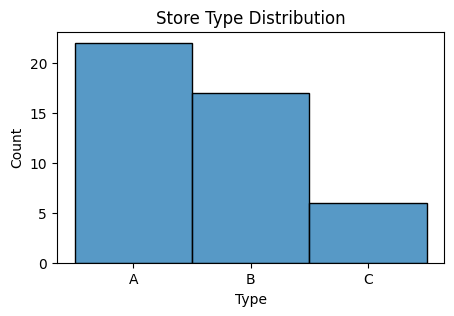

In [ ]:
plt.figure(figsize=(5, 3))
sns.histplot(data = df_stores, x = 'Type')
plt.title('Store Type Distribution')
plt.show()

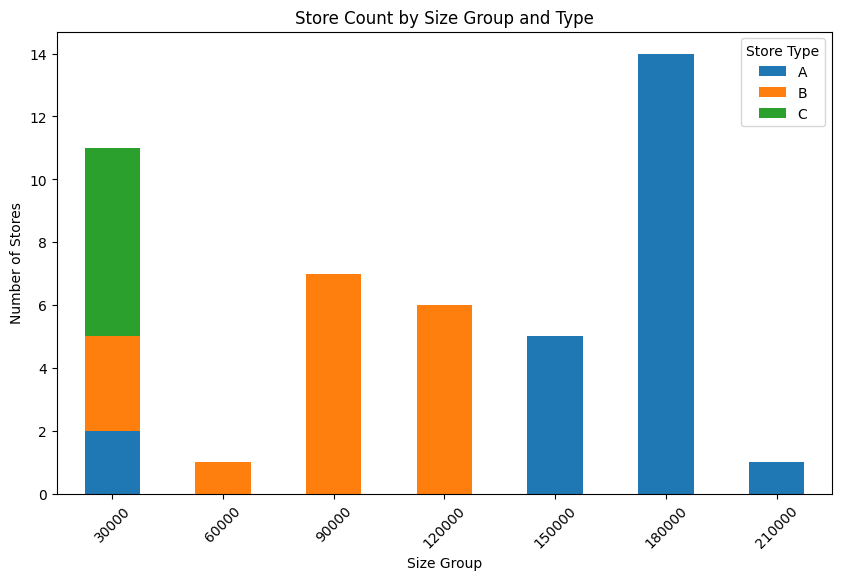

In [ ]:
# split stores by size into 3 groups
bin_width = 30000
df_stores['SizeGroup'] = (df_stores["Size"] // bin_width) * bin_width
# Count the number of stores in each Size Group and Type
grouped = df_stores.groupby(["SizeGroup", "Type"]).size().unstack(fill_value=0)

# Plotting
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# Chart formatting
plt.title("Store Count by Size Group and Type")
plt.xlabel("Size Group")
plt.ylabel("Number of Stores")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_sales

,Store,Date,Weekly_Sales,Type,Size,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,False
1,1,2010-02-12,1641957.44,A,151315,True
2,1,2010-02-19,1611968.17,A,151315,False
3,1,2010-02-26,1409727.59,A,151315,False
4,1,2010-03-05,1554806.68,A,151315,False
...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,B,118221,False
6431,45,2012-10-05,733455.07,B,118221,False
6432,45,2012-10-12,734464.36,B,118221,False
6433,45,2012-10-19,718125.53,B,118221,False


Type A tends to have a larger store size, B ususlly have middle size, and Type C has the smallest store size.

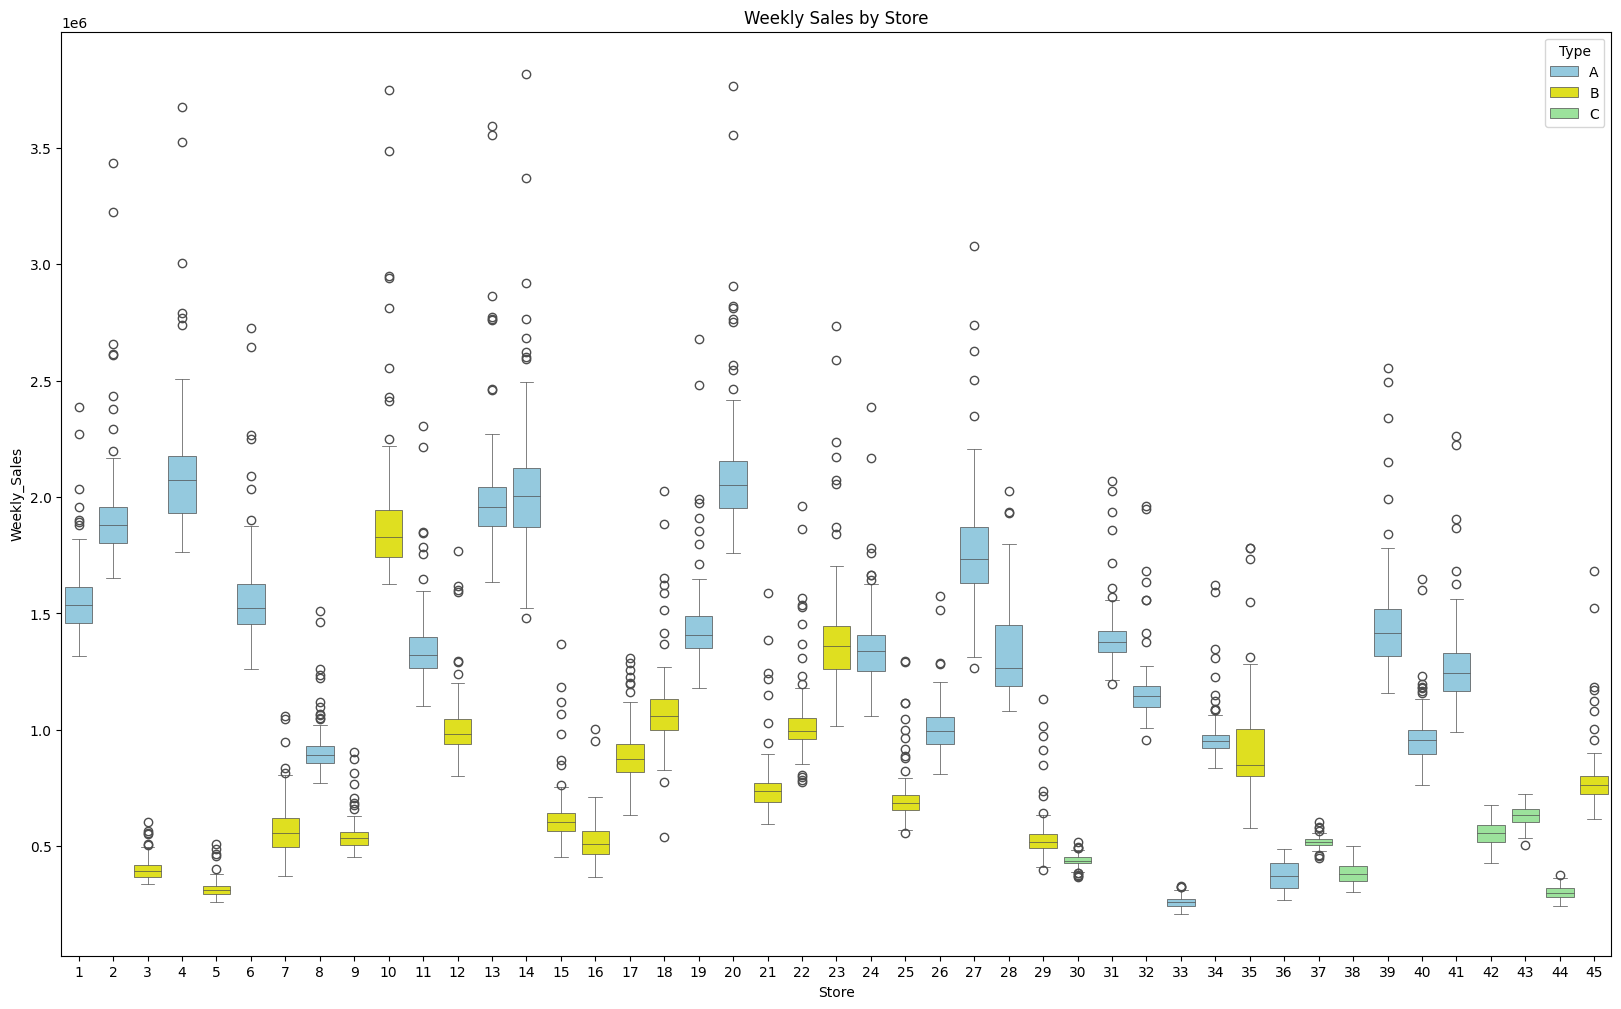

In [ ]:
# plot the box plot for each store's weekly sales
custom_palette = {'A': 'skyblue', 'B': 'yellow', 'C': 'lightgreen'}  # Custom colors

plt.figure(figsize=(20, 12))
sns.boxplot(data=df_sales, x='Store', y='Weekly_Sales', hue='Type', palette=custom_palette, linewidth=0.5)
plt.title('Weekly Sales by Store')
plt.show()

## Check Data Completeness

In [ ]:
df_sales

,Store,Date,Weekly_Sales,Type,Size,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,False
1,1,2010-02-12,1641957.44,A,151315,True
2,1,2010-02-19,1611968.17,A,151315,False
3,1,2010-02-26,1409727.59,A,151315,False
4,1,2010-03-05,1554806.68,A,151315,False
...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,B,118221,False
6431,45,2012-10-05,733455.07,B,118221,False
6432,45,2012-10-12,734464.36,B,118221,False
6433,45,2012-10-19,718125.53,B,118221,False


In [ ]:
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

In [ ]:
# for each store, check whether data is recorded every week, start_date is the first date recorded
def missing_data(df):
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    date_range = pd.date_range(start=start_date, end=end_date, freq='7d')
    date_range = pd.DataFrame(date_range, columns=['Date'])
    date_range['Store'] = df['Store'].unique()[0]
    df = pd.merge(date_range, df, on=['Date', 'Store'], how='left')

    if df['Weekly_Sales'].isnull().sum() > 0:
        print('Missing data for store', df['Store'].unique()[0])
    else:
        return False

In [ ]:
# Function to check all stores
def check_weekly_stores(df):
    stores = df['Store'].unique()
    for store in stores:
        store_df = df[df['Store'] == store]
        result = missing_data(store_df)
        if result == True:
            break
    print('All stores checked and no missing data found')



In [ ]:
check_weekly_stores(df_sales)

All stores checked and no missing data found


## Calculate weighted average and visualize weighted sales data

In [ ]:
# For each "Date", keep the weighted average of the weekly sales for each store, weighted by the store size
df_sales['Weighted_Sales'] = df_sales['Weekly_Sales'] * df_sales['Size']

# Aggregate by Date
df_weighted_avg = df_sales.groupby("Date").apply(
    lambda x: x["Weighted_Sales"].sum() / x["Size"].sum()
).reset_index(name="Weighted_Avg_Sales")

# Add back "IsHoliday" column
df_weighted_avg["IsHoliday"] = df_sales.groupby("Date")["IsHoliday"].max().values

# Display the result
df_weighted_avg

<ipython-input-17-65a134b1b967>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_weighted_avg = df_sales.groupby("Date").apply(


,Date,Weighted_Avg_Sales,IsHoliday
0,2010-02-05,1.344986e+06,False
1,2010-02-12,1.298952e+06,True
2,2010-02-19,1.301398e+06,False
3,2010-02-26,1.178606e+06,False
4,2010-03-05,1.258127e+06,False
...,...,...,...
138,2012-09-28,1.173308e+06,False
139,2012-10-05,1.282149e+06,False
140,2012-10-12,1.240045e+06,False
141,2012-10-19,1.208713e+06,False


In [ ]:
# check if Date is datetime
df_weighted_avg['Date'] = pd.to_datetime(df_weighted_avg['Date'])

In [ ]:
# Set 'Date' column as the index
df_weighted_avg.set_index('Date', inplace=True)


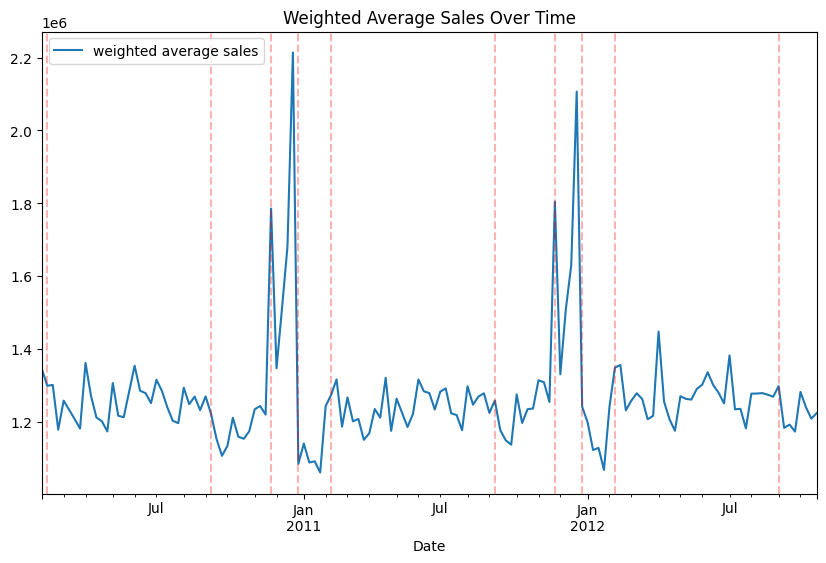

In [ ]:
# Plot the weighted average sales
df_weighted_avg['Weighted_Avg_Sales'].plot(label='weighted average sales', figsize=(10, 6))
plt.title('Weighted Average Sales Over Time')

# Highlight holidays
holiday_dates = df_weighted_avg[df_weighted_avg['IsHoliday'] == True].index
for date in holiday_dates:
    plt.axvline(x=date, color='red', alpha=0.3, linestyle='--')

plt.legend()
plt.show()

Model

In [ ]:
df_store = df_sales.groupby(['Store', 'Date']).agg({
    'Weekly_Sales': 'sum',
    'IsHoliday': 'first'})

In [ ]:
df_store

Weekly_Sales  IsHoliday
Store Date                               
1     2010-02-05    1643690.90      False
      2010-02-12    1641957.44       True
      2010-02-19    1611968.17      False
      2010-02-26    1409727.59      False
      2010-03-05    1554806.68      False
...                        ...        ...
45    2012-09-28     713173.95      False
      2012-10-05     733455.07      False
      2012-10-12     734464.36      False
      2012-10-19     718125.53      False
      2012-10-26     760281.43      False

[6435 rows x 2 columns]

In [ ]:
# Merge with featureson 'store' and 'date'
df = pd.merge(df_store, df_features, on=['Store', 'Date'], how='left')

df = df.drop(columns=['IsHoliday_y'])

df = df.rename(columns={'IsHoliday_x': 'IsHoliday'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   IsHoliday     6435 non-null   bool          
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   MarkDown1     2280 non-null   float64       
 7   MarkDown2     1637 non-null   float64       
 8   MarkDown3     2046 non-null   float64       
 9   MarkDown4     1965 non-null   float64       
 10  MarkDown5     2295 non-null   float64       
 11  CPI           6435 non-null   float64       
 12  Unemployment  6435 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(10), int64(1)
memory usage: 609.7 KB


In [ ]:
# Fill missing markdowns with 0 (assumption: no markdown applied)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)
df['IsHoliday'] = df['IsHoliday'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   IsHoliday     6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   MarkDown1     6435 non-null   float64       
 7   MarkDown2     6435 non-null   float64       
 8   MarkDown3     6435 non-null   float64       
 9   MarkDown4     6435 non-null   float64       
 10  MarkDown5     6435 non-null   float64       
 11  CPI           6435 non-null   float64       
 12  Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(2)
memory usage: 653.7 KB


In [ ]:
df

,Store,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667


In [ ]:
def predict_scale(store_no):
  if (store_no == 0):
    train = df.groupby('Date').agg({
            'Weekly_Sales': 'sum',         # Total weekly sales across all stores
            'MarkDown1': 'sum',           # Sum of markdowns for all stores
            'MarkDown2': 'sum',           # Sum of markdowns for all stores
            'MarkDown3': 'sum',           # Sum of markdowns for all stores
            'MarkDown4': 'sum',           # Sum of markdowns for all stores
            'MarkDown5': 'sum',           # Sum of markdowns for all stores
            'Temperature': 'mean',         # Average temperature across all stores
            'Fuel_Price': 'mean',          # Average fuel price across all stores
            'CPI': 'mean',                 # Average CPI across all stores
            'Unemployment': 'mean',        # Average unemployment across all stores
            'IsHoliday': 'max'             # Sum of holidays (could count holidays per week)
        }).reset_index()



    # Case when store_no is between 1 and 45, filter data for that specific store
  else:
      train = df[df['Store'] == store_no]

  train, test = train_test_split(train, test_size=0.2, random_state=42, shuffle=False)
  train.set_index('Date', inplace=True)
  test.set_index('Date', inplace=True)

  return train, test

# ETS

Forecast example under different scenarios

In [ ]:
store_no = 0
train, test = predict_scale(store_no)

In [ ]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train['Weekly_Sales'], trend = 'add', seasonal = 'add', seasonal_periods=52).fit()
triple_ets_mul = ExponentialSmoothing(train['Weekly_Sales'], trend = 'mul', seasonal = 'mul', seasonal_periods=52).fit()

triple_ets_add_pred = triple_ets_add.forecast(29)
triple_ets_mul_pred = triple_ets_mul.forecast(29)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


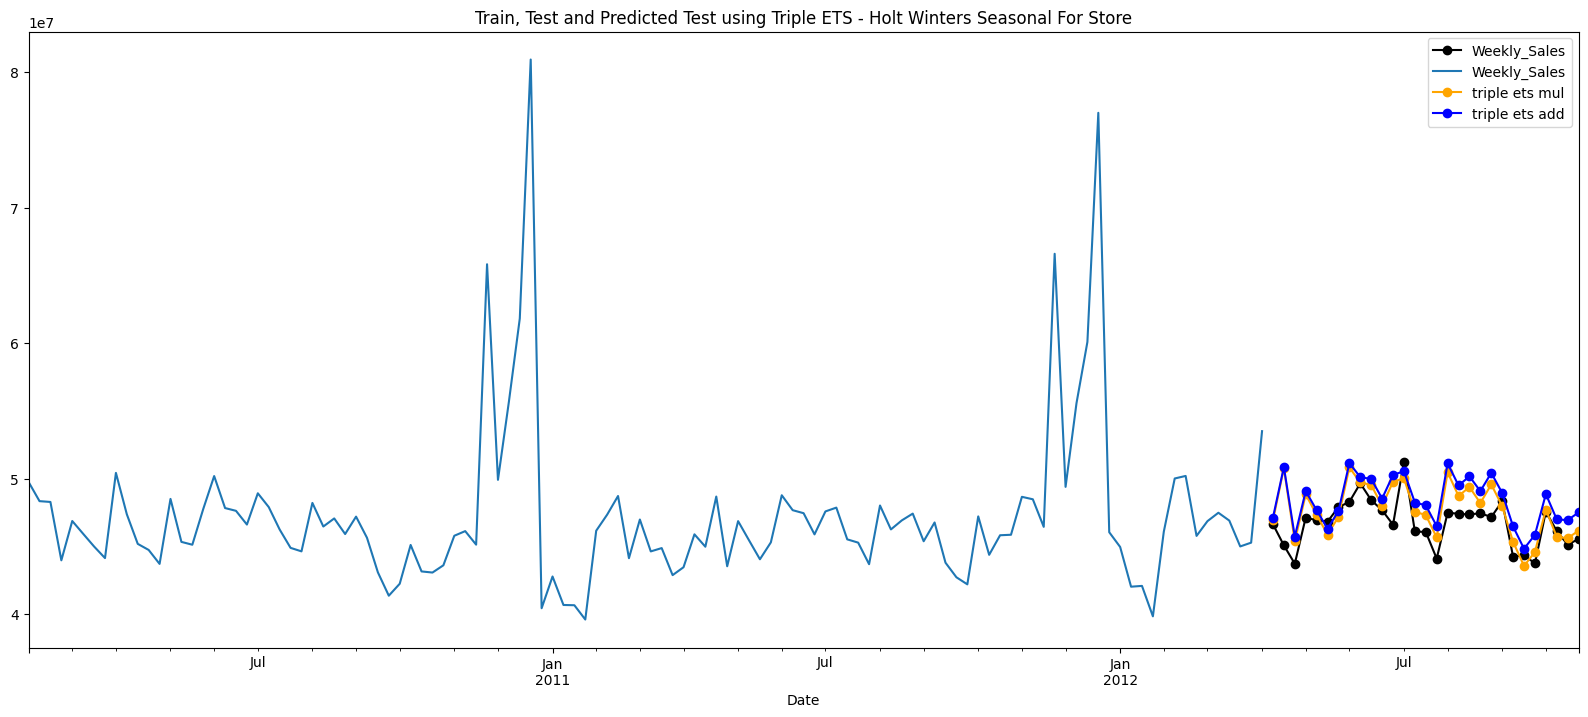

In [ ]:
#plot the train, test, and predictions

ax = test['Weekly_Sales'].plot(marker='o', color='black', figsize=(20,8), legend=True)

train['Weekly_Sales'].plot(figsize=(20,8), legend=True)

triple_ets_mul_pred.plot(marker='o', ax=ax, color='orange', legend=True, label = 'triple ets mul')
triple_ets_add_pred.plot(marker='o', ax=ax, color='blue', legend=True, label = 'triple ets add')

plt.title(f'Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal For Store')
plt.show()

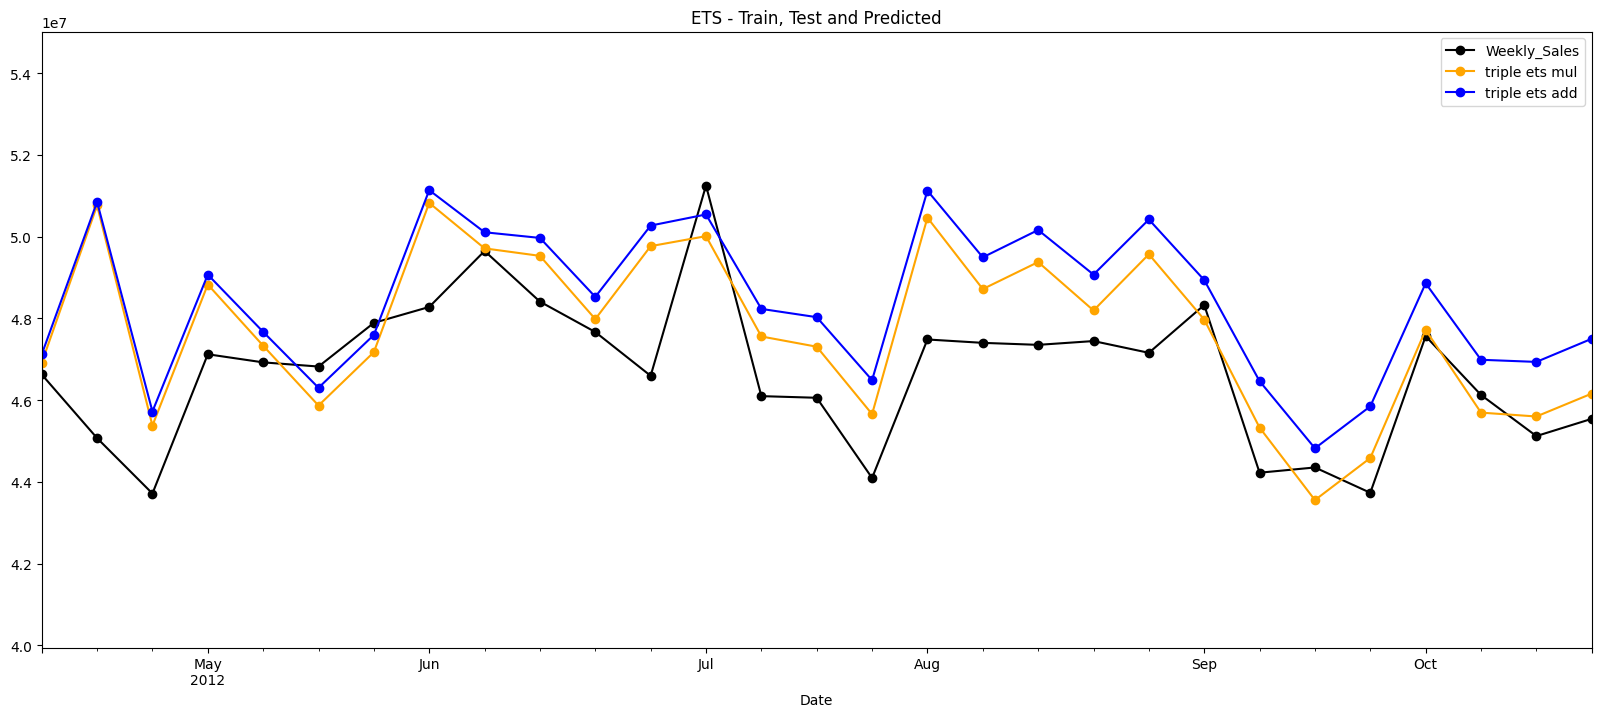

In [ ]:
y_min = min(test['Weekly_Sales'].min(), triple_ets_add_pred.min())
y_max = max(test['Weekly_Sales'].max(), triple_ets_add_pred.max())

# Extend the range by doubling the difference
y_range = y_max - y_min
plt.ylim(y_min - 0.5*y_range, y_max + 0.5*y_range)

ax = test['Weekly_Sales'].plot(marker='o', color='black', figsize=(20,8), legend=True)

triple_ets_mul_pred.plot(marker='o', ax=ax, color='orange', legend=True, label = 'triple ets mul')

triple_ets_add_pred.plot(marker='o', ax=ax, color='blue', legend=True, label = 'triple ets add')

plt.title('ETS - Train, Test and Predicted')
plt.show()

# SARIMAX

In [ ]:
# Fit the best SARIMA-X model
final_mod = sm.tsa.SARIMAX(train['Weekly_Sales'],
                           exog=train[['IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'] + markdown_cols],
                           order= (1,0,1),
                           seasonal_order=(1, 1, 1, 52),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
final_results = final_mod.fit()

# Print the model summary
print(final_results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -124.831
Date:                            Wed, 26 Feb 2025   AIC                            279.662
Time:                                    02:21:59   BIC                            280.854
Sample:                                02-05-2010   HQIC                           271.625
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
IsHoliday     6.008e-09   5.61e-06      0.001      0.999    -1.1e-05     1.1e-05
Temperature   1.063e+05      

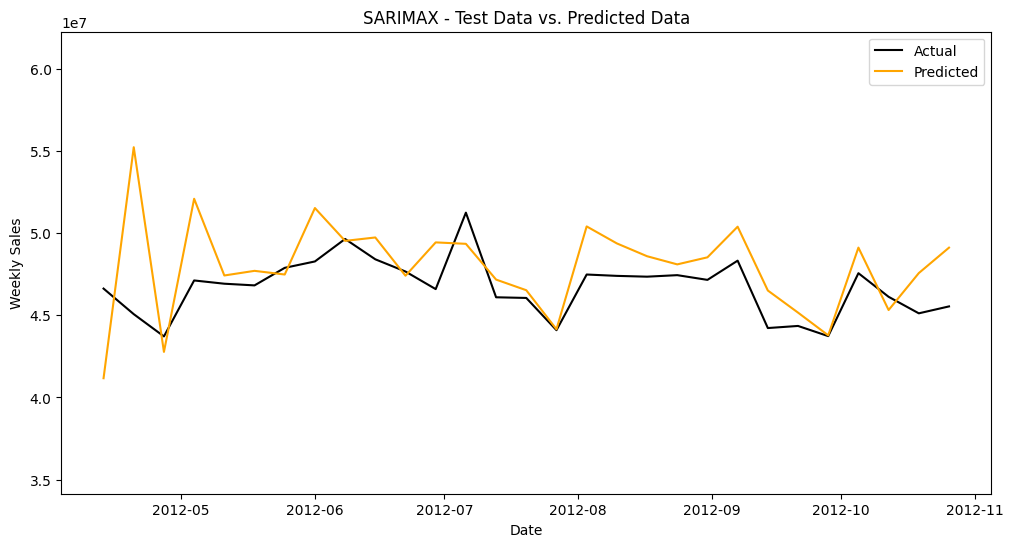

In [ ]:
# Make predictions on test data
test_predictions = final_results.get_forecast(steps=len(test), exog=test[['IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'] + markdown_cols])
sarimax_pred = test_predictions.predicted_mean

# Visualize predictions
plt.figure(figsize=(12, 6))
y_min = min(test['Weekly_Sales'].min(), sarimax_pred.min())
y_max = max(test['Weekly_Sales'].max(), sarimax_pred.max())

# Extend the range by doubling the difference
y_range = y_max - y_min
plt.ylim(y_min - 0.5*y_range, y_max + 0.5*y_range)
plt.plot(test.index, test['Weekly_Sales'], label='Actual', color='black')
plt.plot(test.index, sarimax_pred, label='Predicted', color='orange')
#plt.fill_between(test.index, predicted_conf_int.iloc[:, 0], predicted_conf_int.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('SARIMAX - Test Data vs. Predicted Data')
plt.legend()
plt.show()

SVD-SARIMAX

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.linalg import svd
from sklearn.impute import SimpleImputer

In [ ]:
def preprocess_svd(train, n_components=5):

    train_values = train.values

    # Handle missing values using mean imputation
    imputer = SimpleImputer(strategy="mean")
    train_values = imputer.fit_transform(train_values)

    # Apply SVD
    U, s, Vt = svd(train_values, full_matrices=False)

    # Keep only n_components
    S_reduced = np.diag(s[:n_components])
    U_reduced = U[:, :n_components]
    Vt_reduced = Vt[:n_components, :]

    # Reconstruct reduced-rank matrix
    train_reduced = np.dot(U_reduced, np.dot(S_reduced, Vt_reduced))

    return pd.DataFrame(train_reduced, index=train.index, columns=train.columns)

def seasonal_arima_svd(train, test, n_components=5):

    horizon = len(test)  # Number of weeks to forecast

    # Apply SVD preprocessing
    train_reduced = preprocess_svd(train, n_components=n_components)

    for store in train_reduced.columns:
        series = train_reduced[store].dropna()

        if series.isnull().sum() > len(series) / 3:
            # Fallback: Use last known value if too many missing
            print(f"Fallback for Store: {store}")
            test[store] = series.iloc[-1]
        else:
            try:
                # Fit Seasonal ARIMA (SARIMA)
                model = ARIMA(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
                model_fit = model.fit()

                # Forecast
                forecast_values = model_fit.forecast(steps=horizon)
                test[store] = forecast_values.values
            except Exception as e:
                print(f"ARIMA failed for Store {store}, using last value. Error: {e}")
                test[store] = series.iloc[-1]  # Fallback

    return test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

train_matrix = train.values  # Converts DataFrame to NumPy array
test_matrix = test.values

# Standardize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_matrix)
test_scaled = scaler.transform(test_matrix)

# Apply SVD for dimensionality reduction
n_components = 10  # You can tune this
svd = TruncatedSVD(n_components=n_components)
train_reduced = svd.fit_transform(train_scaled)

# Train SARIMA models on reduced components
sarima_models = []
forecasts = []

for i in range(n_components):
    series = train_reduced[:, i]  # Select reduced component
    #model = ARIMA(series, order=(0, 1, 1), seasonal_order=(1, 1, 1, 52))
    model = SARIMAX(series, exog=train[['IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'] + markdown_cols], order=(1,1,1), seasonal_order=(1,1,1,52))  # Weekly seasonality
    results = model.fit()
    sarima_models.append(results)

    # Forecast future values
    test_predictions = results.get_forecast(steps=len(test), exog=test[['IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'] + markdown_cols])
    forecasts.append(test_predictions.predicted_mean)

# Convert forecasts back using inverse SVD
forecasts = np.array(forecasts).T  # Transpose to match dimensions
test_reconstructed = svd.inverse_transform(forecasts)  # Inverse SVD
test_reconstructed = scaler.inverse_transform(test_reconstructed)  # Reverse standardization

# Convert back to DataFrame
test_pred_df = pd.DataFrame(test_reconstructed, index=test.index, columns=test.columns)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:4

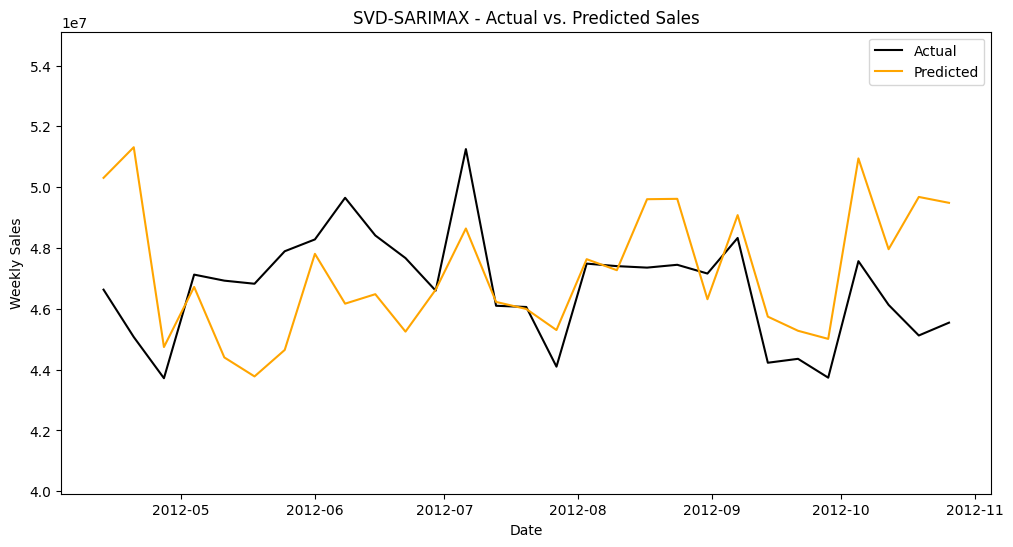

In [ ]:
# Visualization for a specific column (e.g., store or department)
plt.figure(figsize=(12, 6))
y_min = min(test['Weekly_Sales'].min(), test_pred_df['Weekly_Sales'].min())
y_max = max(test['Weekly_Sales'].max(), test_pred_df['Weekly_Sales'].max())
y_range = y_max - y_min
plt.ylim(y_min - 0.5*y_range, y_max + 0.5*y_range)
plt.plot(test.index, test['Weekly_Sales'], label='Actual', color='black')
plt.plot(test.index, test_pred_df['Weekly_Sales'], label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title(f'SVD-SARIMAX - Actual vs. Predicted Sales')
plt.legend()
plt.show()

In [ ]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_mul = ExponentialSmoothing(train['Weekly_Sales'], trend = 'mul', seasonal = 'mul', seasonal_periods=52).fit()
triple_ets_mul_pred = triple_ets_mul.forecast(29)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
average = pd.DataFrame(columns = ['Weekly_Sales'])

In [ ]:
average = pd.DataFrame(index=test_pred_df.index)
average['Weekly_Sales'] = (triple_ets_mul_pred + test_pred_df['Weekly_Sales']) / 2

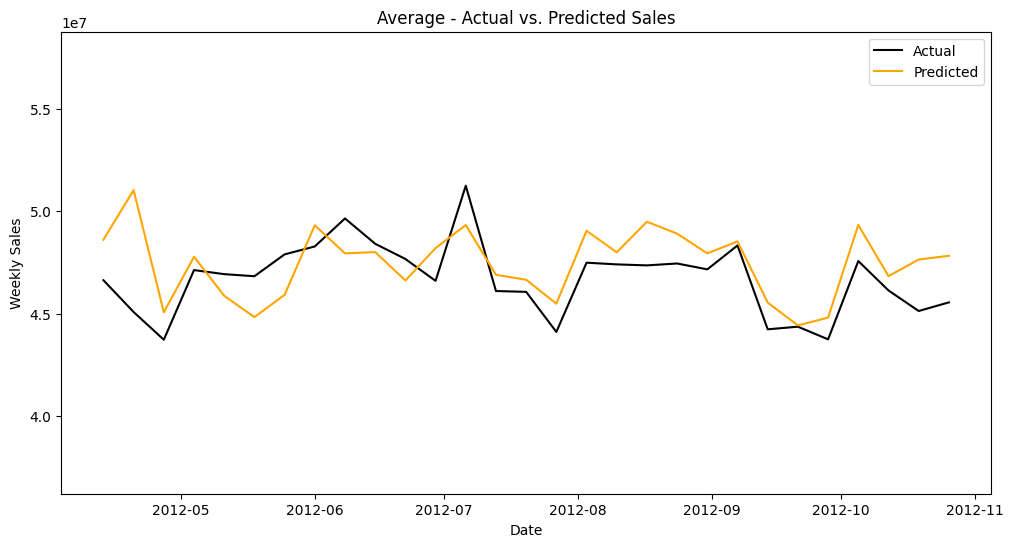

In [ ]:
plt.figure(figsize=(12, 6))
y_min = min(test['Weekly_Sales'].min(), average['Weekly_Sales'].min())
y_max = max(test['Weekly_Sales'].max(), average['Weekly_Sales'].max())
y_range = y_max - y_min
plt.ylim(y_min - 1*y_range, y_max + 1*y_range)
plt.plot(test.index, test['Weekly_Sales'], label='Actual', color='black')
plt.plot(test.index, average['Weekly_Sales'], label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title(f'Average - Actual vs. Predicted Sales')
plt.legend()
plt.show()

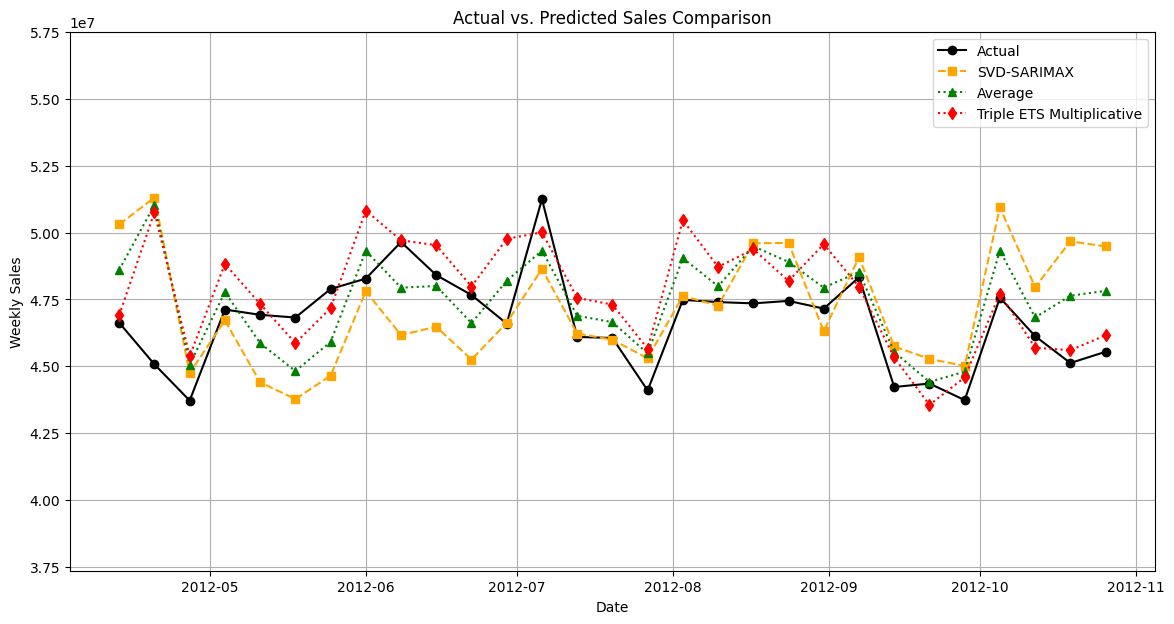

In [ ]:
plt.figure(figsize=(14, 7))

# 获取 y 轴范围
y_min = min(test['Weekly_Sales'].min(),
            test_pred_df['Weekly_Sales'].min(),
            average['Weekly_Sales'].min(),
            triple_ets_add_pred.min(),
            triple_ets_mul_pred.min())

y_max = max(test['Weekly_Sales'].max(),
            test_pred_df['Weekly_Sales'].max(),
            average['Weekly_Sales'].max(),
            triple_ets_add_pred.max(),
            triple_ets_mul_pred.max())

y_range = y_max - y_min
plt.ylim(y_min - 0.8 * y_range, y_max + 0.8 * y_range)

# 画 Actual Sales
plt.plot(test.index, test['Weekly_Sales'], label='Actual', color='black', marker='o')

# 画 SVD-SARIMAX 预测
plt.plot(test.index, test_pred_df['Weekly_Sales'], label='SVD-SARIMAX', color='orange', linestyle='dashed', marker='s')

# 画 Average 预测
plt.plot(test.index, average['Weekly_Sales'], label='Average', color='green', linestyle='dotted', marker='^')


# 画 Triple ETS (mul)
plt.plot(test.index, triple_ets_mul_pred, label='Triple ETS Multiplicative', color='red', linestyle='dotted', marker='d')

# 添加图例和标签
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs. Predicted Sales Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def compute_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

In [ ]:
actual_sales = test['Weekly_Sales']/1e7

# Compute metrics for each model
sarimax_rmse, sarimax_mae, sarimax_mape = compute_metrics(actual_sales, test_pred_df['Weekly_Sales']/1e7)
ets_rmse, ets_mae, ets_mape = compute_metrics(actual_sales, triple_ets_mul_pred/1e7)
avg_rmse, avg_mae, avg_mape = compute_metrics(actual_sales, average['Weekly_Sales']/1e7)

metrics_df = pd.DataFrame({
    "Model": ["SARIMAX", "ETS", "Average (SARIMAX + ETS)"],
    "RMSE": [sarimax_rmse, ets_rmse, avg_rmse],
    "MAE": [sarimax_mae, ets_mae, avg_mae],
    "MAPE (%)": [sarimax_mape, ets_mape, avg_mape]
})

print("Performance Metrics:")
print(metrics_df)

average_pct_change = average['Weekly_Sales'].pct_change() * 100

actual_pct_change = test['Weekly_Sales'].pct_change() * 100

percentage_change_df = pd.DataFrame({
    "Sales % Change": average_pct_change
})

print(percentage_change_df)

Performance Metrics:
                     Model      RMSE       MAE  MAPE (%)
0                  SARIMAX  0.247087  0.193907  4.154784
1                      ETS  0.176112  0.132502  2.854034
2  Average (SARIMAX + ETS)  0.179441  0.144523  3.107670
            Sales % Change
Date                      
2012-04-13             NaN
2012-04-20        4.998133
2012-04-27      -11.713908
2012-05-04        6.022844
2012-05-11       -3.993308
2012-05-18       -2.276695
2012-05-25        2.429312
2012-06-01        7.418808
2012-06-08       -2.789430
2012-06-15        0.133831
2012-06-22       -2.893972
2012-06-29        3.394973
2012-07-06        2.340473
2012-07-13       -4.935910
2012-07-20       -0.514502
2012-07-27       -2.511033
2012-08-03        7.847101
2012-08-10       -2.150287
2012-08-17        3.121217
2012-08-24       -1.184205
2012-08-31       -1.969548
2012-09-07        1.219041
2012-09-14       -6.164833
2012-09-21       -2.457436
2012-09-28        0.858850
2012-10-05       10.12